In [25]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import skmob
from skmob.preprocessing import filtering
from skmob.preprocessing import compression
from skmob.preprocessing import detection
from skmob.tessellation.tilers import tiler
from skmob.utils import plot

import osmnx as ox

import folium
from folium import plugins


# Import Data

Importazione dei dati con le traiettorie di auto private a Milano in uno span temporale di circa 1 settimana:

In [26]:
data = pd.read_csv('Milano_Trajectories_Data/MilanoData.csv', parse_dates = ['datetime'])
data.head()

userid            datetime        lat       lon
0    1059 2007-04-05 07:47:02  45.474777  9.210948
1    1059 2007-04-05 08:16:00  45.474777  9.210948
2    1059 2007-04-05 08:44:53  45.474777  9.210948
3    1059 2007-04-05 14:22:54  45.474777  9.210948
4    1059 2007-04-05 17:30:29  45.474777  9.210948

Creo un **trajectory dataframe**:

In [27]:
traj_data = skmob.TrajDataFrame(data,
                                longitude = 'lon', 
                                latitude = 'lat',
                                datetime = 'datetime', 
                                user_id = 'userid')
traj_data.sort_values(by = ['uid', 'datetime'], inplace = True)
traj_data.head()       

uid            datetime        lat       lng
742573  193 2007-04-03 08:01:00  45.377006  9.277484
742574  193 2007-04-03 08:01:55  45.391857  9.261229
742575  193 2007-04-03 08:03:16  45.409712  9.262036
742576  193 2007-04-03 08:05:52  45.415662  9.265230
742577  193 2007-04-03 10:10:51  45.423224  9.275968

Definisco la funzione `get_stats()` con cui posso andae a calcolare le statistiche di un qualsiasi trajectory dataframe:

In [28]:
def get_stats(df):
    
    len_IDs = len(df['uid'].unique())
    min_date = min(df['datetime'])
    max_date = max(df['datetime'])
    
    print(f'Shape: {df.shape}')
    print(f'N° IDs: { len_IDs }')
    print(f'Datetime range: { min_date } - { max_date }')

get_stats(traj_data)

Shape: (1806293, 4)
N° IDs: 17087
Datetime range: 2007-04-01 00:00:02 - 2007-04-07 23:59:25


# Restrict to the first k-vehicles

Rstringo l'analisi ai **primi k veicoli** presenti all'interno del trajectory dataframe

In [29]:
k = len(traj_data['uid'].unique())

tdf = traj_data[ traj_data['uid'].isin(traj_data['uid'].unique()[0:k]) ]
get_stats(tdf)  
tdf.head()

Shape: (1806293, 4)
N° IDs: 17087
Datetime range: 2007-04-01 00:00:02 - 2007-04-07 23:59:25


uid            datetime        lat       lng
742573  193 2007-04-03 08:01:00  45.377006  9.277484
742574  193 2007-04-03 08:01:55  45.391857  9.261229
742575  193 2007-04-03 08:03:16  45.409712  9.262036
742576  193 2007-04-03 08:05:52  45.415662  9.265230
742577  193 2007-04-03 10:10:51  45.423224  9.275968

# Filter Trajectories

L'idea qui è di creare un meccanismo per scegliere la giusa velocità. Partendo da una velocità bassa e salendo con la velocità, esisterà una velocità di soglia oltre la quale il numero di punti filtrati nelle traiettorie non varia più. Questa è la velocità che voglio impostare.

Infatti possiamo iterativamente testare diverse `max_speed_kmh` e per ognuna di esse misuriamo quanti punti sono filtrati dalla traiettoria.
Arriverà un valore della `max_speed_kmh` tale per cui il numero di punti filtrati non aumenta significativamente.

Max Speed: 50
Shape: (1099394, 4)
N° IDs: 17087
Datetime range: 2007-04-01 00:00:02 - 2007-04-07 23:59:25
Max Speed: 75
Shape: (1357991, 4)
N° IDs: 17087
Datetime range: 2007-04-01 00:00:02 - 2007-04-07 23:59:25
Max Speed: 100
Shape: (1611622, 4)
N° IDs: 17087
Datetime range: 2007-04-01 00:00:02 - 2007-04-07 23:59:25
Max Speed: 125
Shape: (1771985, 4)
N° IDs: 17087
Datetime range: 2007-04-01 00:00:02 - 2007-04-07 23:59:25
Max Speed: 150
Shape: (1804846, 4)
N° IDs: 17087
Datetime range: 2007-04-01 00:00:02 - 2007-04-07 23:59:25
Max Speed: 175
Shape: (1806218, 4)
N° IDs: 17087
Datetime range: 2007-04-01 00:00:02 - 2007-04-07 23:59:25
Max Speed: 200
Shape: (1806288, 4)
N° IDs: 17087
Datetime range: 2007-04-01 00:00:02 - 2007-04-07 23:59:25
Max Speed: 225
Shape: (1806289, 4)
N° IDs: 17087
Datetime range: 2007-04-01 00:00:02 - 2007-04-07 23:59:25
Max Speed: 250
Shape: (1806290, 4)
N° IDs: 17087
Datetime range: 2007-04-01 00:00:02 - 2007-04-07 23:59:25
Max Speed: 275
Shape: (1806291, 4)
N° I

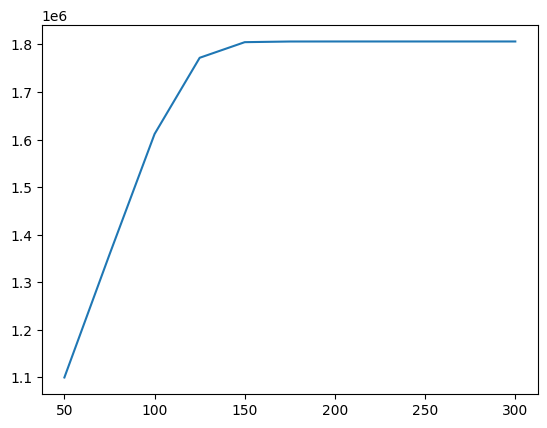

In [30]:
list_max_speed = range(50, 325, 25)
list_shapes = []
for speed in list_max_speed:
    
    tdf_f = filtering.filter(tdf, max_speed_kmh = speed)
    
    print('='*50)
    print(f'Max Speed: {speed}')
    get_stats(tdf_f)
    print('='*50)
    
    list_shapes.append(len(tdf_f))
    
plt.plot(list_max_speed, list_shapes);

Dopo aver fatto la simulazione di cui sopra, scelgo definintivamente una `max_speed_kmh`:

In [31]:
tdf_f = filtering.filter(tdf, max_speed_kmh = 150)
get_stats(tdf_f)

Shape: (1804846, 4)
N° IDs: 17087
Datetime range: 2007-04-01 00:00:02 - 2007-04-07 23:59:25


# Compress Trajectories


L'obiettivo della **compression** è quella di comprimere e ridurre il numero di punti GPS della traiettoria, perché i dati geospaziali sono molti. 
In questo caso i punti **entro un raggio di `spatial_radius_km` km** vengono completamente collassati su un solo punto, semplificando la traiettoria.

Shape: (1529549, 4)
N° IDs: 17087
Datetime range: 2007-04-01 00:00:02 - 2007-04-07 23:59:25
Shape: (1405801, 4)
N° IDs: 17087
Datetime range: 2007-04-01 00:00:02 - 2007-04-07 23:59:25
Shape: (1306918, 4)
N° IDs: 17087
Datetime range: 2007-04-01 00:00:02 - 2007-04-07 23:59:25


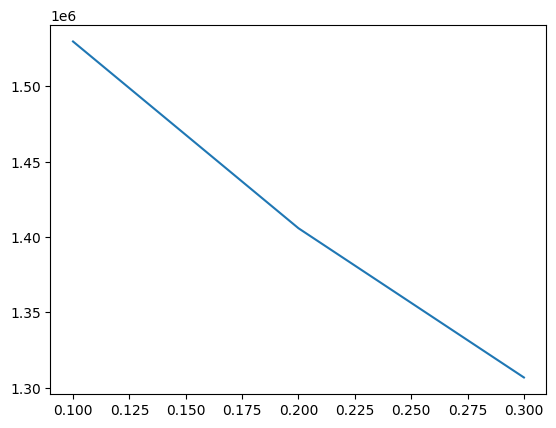

In [33]:
list_radius = [j/10 for j in range(1, 4)]
list_shapes = []

for radius in list_radius:
    
    tdf_fc = compression.compress(tdf_f, spatial_radius_km = radius)
    
    print('='*50)
    get_stats(tdf_fc)
    print('='*50)
    
    list_shapes.append( len(tdf_fc) )
    

plt.plot(list_radius, list_shapes)


Alla fine scelgo uno `spatial_radius_km` pari a 200 m:

In [34]:
tdf_fc = compression.compress(tdf_f, spatial_radius_km = 0.2)
get_stats(tdf_fc)

Shape: (1405801, 4)
N° IDs: 17087
Datetime range: 2007-04-01 00:00:02 - 2007-04-07 23:59:25


# Stop Detection

Identifichiamo le **locazioni di STOP** come la **fine di un viaggio** e l'**inizio di un viaggio successivo**.

La semantica della funzione è di etichettare come **STOP LOCATION** ogni location tale per cui **entro un raggio di `spatial_radius_km` km**, il veicolo non è uscito per **almeno `minutes_for_a_stop` min**.

In [35]:
tdf_fcs = detection.stay_locations(tdf_fc, minutes_for_a_stop = 30, spatial_radius_km = 0.3)
tdf_fcs.head()

uid            datetime        lat       lng    leaving_datetime
0  193 2007-04-03 08:05:52  45.415662  9.265230 2007-04-03 10:10:51
1  193 2007-04-03 10:17:23  45.437518  9.231097 2007-04-03 11:59:30
2  193 2007-04-03 12:01:53  45.431064  9.266437 2007-04-03 14:18:19
3  193 2007-04-03 14:18:19  45.416912  9.260658 2007-04-03 15:45:41
4  193 2007-04-03 15:45:41  45.417499  9.266005 2007-04-04 11:18:24

In [36]:
get_stats(tdf_fcs)

Shape: (140460, 5)
N° IDs: 14615
Datetime range: 2007-04-01 00:00:03 - 2007-04-07 23:17:03


# Tessellation

L'operazione di **Mapping** associa ad ogni punto la tile che contiene quello specifico punto.
Si aggiunge al Trajectory Dataframe la `tile_ID`, che semplicemente significa che ogni punto della traiettoria, ha adesso associato una singola tile della tessellation.

Talvolta è possibile che da questa operazione compaiano dei valori NaN. Li andiamo ad rimuovere, tenendo solo i punti di traiettoria che ricadono nelle tessellation.

In [37]:
location = ox.geocode_to_gdf('Milan Metropolitan City, Lombardy, Italy')
gdf_tessellation = tiler.get('squared', base_shape = location, meters = 2000)
print(gdf_tessellation.shape)
gdf_tessellation.head()

(930, 2)


tile_ID                                           geometry
0       0  POLYGON ((8.70610 45.50244, 8.70610 45.51503, ...
1       1  POLYGON ((8.70610 45.51503, 8.70610 45.52762, ...
2       2  POLYGON ((8.70610 45.52762, 8.70610 45.54021, ...
3       3  POLYGON ((8.70610 45.54021, 8.70610 45.55279, ...
4       4  POLYGON ((8.70610 45.55279, 8.70610 45.56537, ...

Visualizzo graficamente le tessellations ottenute:

In [38]:
tess_style = {'color':'lime', 'fillColor':'black', 'weight': 2, }
popup_features=['tile_ID']
map = plot.plot_gdf(gdf_tessellation, zoom = 13, style_func_args = tess_style, popup_features = popup_features)
map

# Mapping Stops to Tessellations

In [39]:
tdf_fcs_mapped = tdf_fcs.mapping(gdf_tessellation)
tdf_fcs_mapped.head()

uid            datetime        lat       lng    leaving_datetime tile_ID
0  193 2007-04-03 08:05:52  45.415662  9.265230 2007-04-03 10:10:51     664
1  193 2007-04-03 10:17:23  45.437518  9.231097 2007-04-03 11:59:30     624
2  193 2007-04-03 12:01:53  45.431064  9.266437 2007-04-03 14:18:19     665
3  193 2007-04-03 14:18:19  45.416912  9.260658 2007-04-03 15:45:41     644
4  193 2007-04-03 15:45:41  45.417499  9.266005 2007-04-04 11:18:24     664

Calcoliamo **quanto sono le tile_ID** in cui sono avvenute delle **STOPS**.

In [40]:
len(tdf_fcs_mapped['tile_ID'].unique())

206

Tutte le traiettorie hanno correttamente assegnata una `tile_ID`:

In [41]:
tdf_fcs_mapped[tdf_fcs_mapped['tile_ID'].isnull()]

Empty TrajDataFrame
Columns: [uid, datetime, lat, lng, leaving_datetime, tile_ID]
Index: []

Per scrupolo, vado ad escludere potenziali valori `NaN`

In [42]:
tdf_fcs_mapped = tdf_fcs_mapped[ ~ tdf_fcs_mapped['tile_ID'].isna() ]

Vediamo **per ogni `tile_ID`** quante sono le **stops**:

tile_ID
387    2879
673    2545
675    2535
540    2249
634    2174
Name: uid, dtype: int64


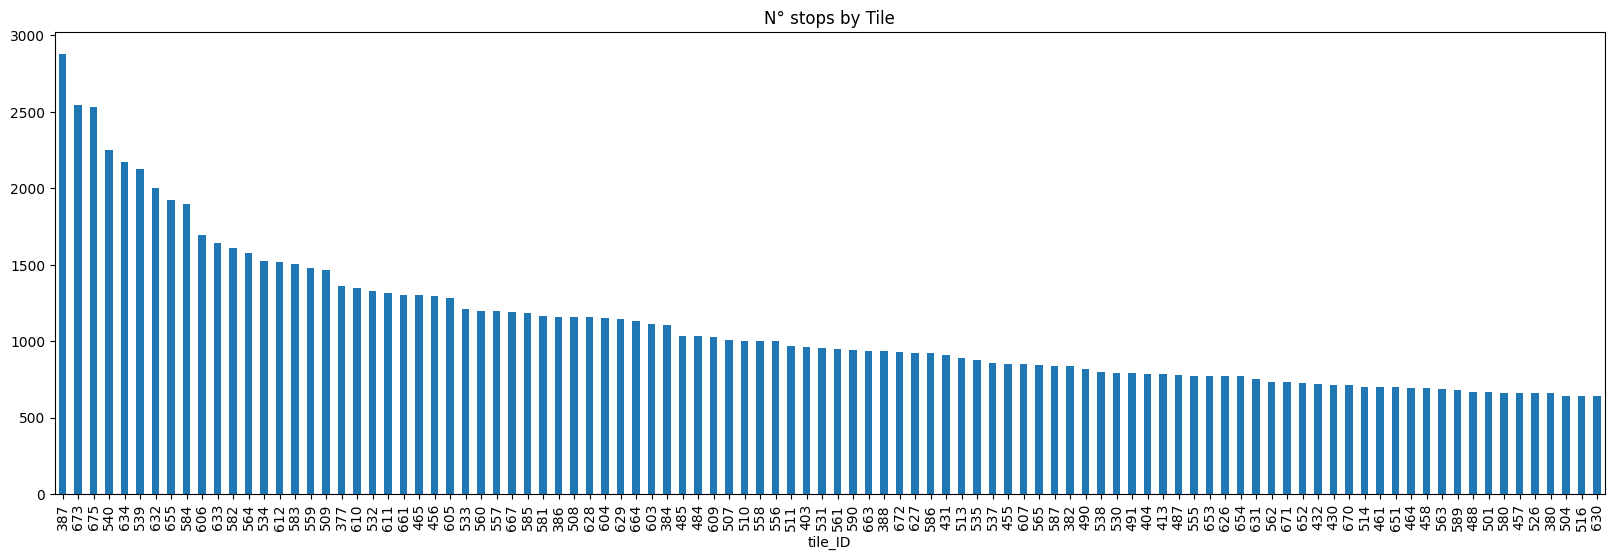

In [45]:
series_StopsByTile = tdf_fcs_mapped.groupby('tile_ID')['uid'].count().sort_values(ascending = False)
print(series_StopsByTile.head())

fig, ax = plt.subplots(figsize = (20, 6))
series_StopsByTile.head(100).plot(kind = 'bar', title = 'N° stops by Tile');

Plotto la CDF delle **stops by tile** per studiare la distribuzione delle stops nelle varie tiles:

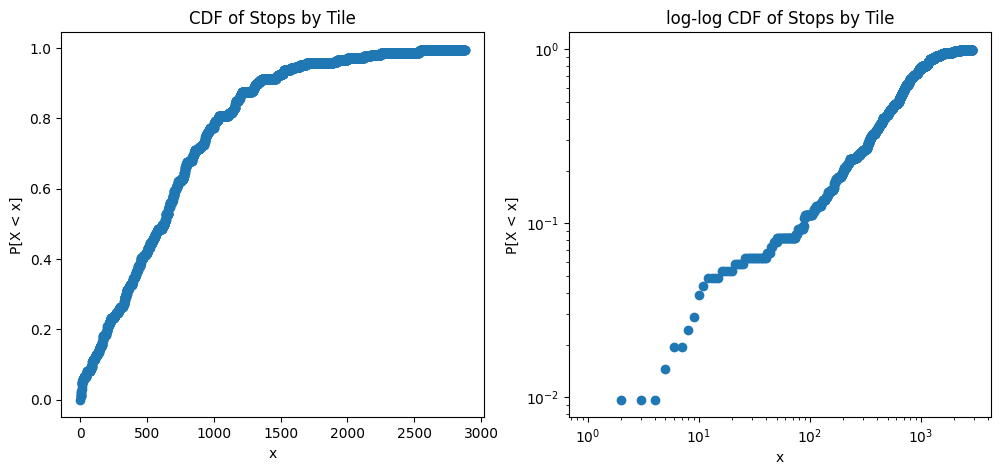

In [46]:

def CDF_from_scratch(fit_on, return_val = []):
    a = np.array(fit_on)
    risu = []
    for j in return_val:
        freq = np.sum(a < j)/len(a)
        risu.append(freq)
    return np.array(risu)

x = np.arange(1, max(series_StopsByTile) + 1)

CDF_StopsByTile = CDF_from_scratch( fit_on = series_StopsByTile,
                                    return_val = x )

fig, ax = plt.subplots(1, 2, figsize = (12, 5))

ax[0].scatter(x, CDF_StopsByTile)
ax[0].set_xlabel('x')
ax[0].set_ylabel('P[X < x]')
ax[0].set_title('CDF of Stops by Tile');

ax[1].scatter(x, CDF_StopsByTile)
ax[1].set_xlabel('x')
ax[1].set_ylabel('P[X < x]')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('log-log CDF of Stops by Tile');

Plotto la CCDF delle **stops by tile** per studiare la distribuzione delle stops nelle varie tiles:

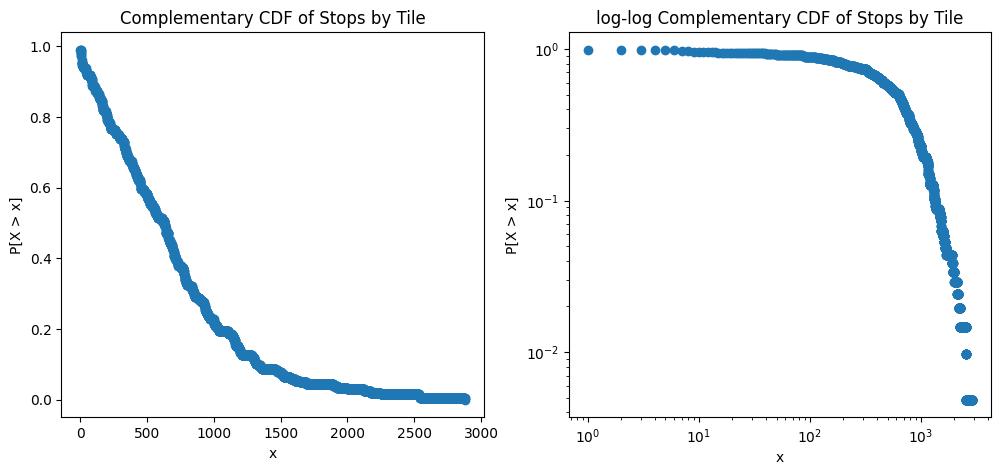

In [47]:

def CCDF_from_scratch(fit_on, return_val = []):
    a = np.array(fit_on)
    risu = []
    for j in return_val:
        freq = np.sum(a > j)/len(a)
        risu.append(freq)
    return np.array(risu)

x = np.arange(1, max(series_StopsByTile) + 1)
CCDF_StopsByTile = CCDF_from_scratch( fit_on = series_StopsByTile,
                                              return_val = x )


fig, ax = plt.subplots(1, 2, figsize = (12, 5))

ax[0].scatter(x, CCDF_StopsByTile)
ax[0].set_xlabel('x')
ax[0].set_ylabel('P[X > x]')
ax[0].set_title('Complementary CDF of Stops by Tile');

ax[1].scatter(x, CCDF_StopsByTile)
ax[1].set_xlabel('x')
ax[1].set_ylabel('P[X > x]')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('log-log Complementary CDF of Stops by Tile');

Di seguito visualizzo le **stops by tile** sulla mappa:

In [48]:
tess_style = {'color':'lime', 'fillColor':'black', 'weight': 2}
popup_features=['tile_ID']
map = plot.plot_gdf( gdf_tessellation, 
                     zoom = 13, 
                     style_func_args = tess_style, 
                     popup_features = popup_features )
map = tdf_fcs_mapped.plot_stops(map_f = map)
map

Evidenzio con una **cloropleth maph** quali sono le `tile_ID` che hanno riscontrato più stops:

In [49]:
def plot_cloropleth(tdf, tessellation, map_f = None):
    
    if map_f is None:
        m = folium.Map(location = [ tdf['lat'].mean(), tdf['lng'].mean() ], 
                       zoom_start = 13, 
                       control_scale=True)
    else:
        m = map_f
    
    points_per_tile = tdf.groupby('tile_ID').count().reset_index()[['tile_ID', 'uid']].rename(columns={'uid': 'n_points'})

    m.choropleth(
        geo_data = tessellation.reset_index().set_index('tile_ID').to_json(),
        data = points_per_tile,
        columns=['tile_ID', 'n_points'],
        key_on='feature.id',
        fill_color='YlGn',
        legend_name='Number of points',
        highlight=True
    )
    return m

tess_style = {'color':'black', 'fillColor':'black', 'weight': 2}

popup_features=['tile_ID']

map = plot_cloropleth(tdf_fcs_mapped, gdf_tessellation)

map = plot.plot_gdf(gdf_tessellation, 
                    map_f = map,
                    zoom=9,
                    style_func_args = tess_style, 
                    popup_features=popup_features)

map

In [50]:
tdf_fcs_mapped.to_csv('tdf_fcs_mapped.csv')